In [117]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC, SVC

import plotly.express as px
from matplotlib import pyplot as plt

import missingno as msno
import pandas as pd
import numpy as np
import seaborn as sns
import os
import re

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

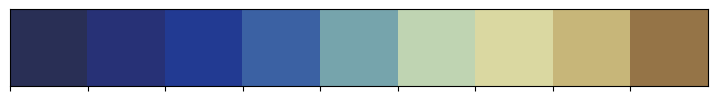

In [118]:
cm = ["#273176","#3B61A3","#76A4AC","#BFD4B2","#DAD8A1"]
gradient = ["#292F55","#273176","#223A92","#3B61A3","#76A4AC","#BFD4B2","#DAD8A1","#C7B679","#957447"]
sns.palplot(gradient)

### 1. Exploratory Data Analysis (EDA)


In [119]:
df_tr = pd.read_csv(f"train.csv").set_index("PassengerId", drop=True)
df_ts = pd.read_csv(f"test.csv").set_index("PassengerId", drop=True)
df = pd.concat([df_tr, df_ts], axis=0)
df.head(10).style.background_gradient(cmap='Blues')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0.000000,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.250000,nan,S
2,1.000000,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.000000,1,0,PC 17599,71.283300,C85,C
3,1.000000,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.925000,nan,S
4,1.000000,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.100000,C123,S
5,0.000000,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.050000,nan,S
6,0.000000,3,"Moran, Mr. James",male,nan,0,0,330877,8.458300,nan,Q
7,0.000000,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.862500,E46,S
8,0.000000,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.075000,nan,S
9,1.000000,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.133300,nan,S


<Axes: >

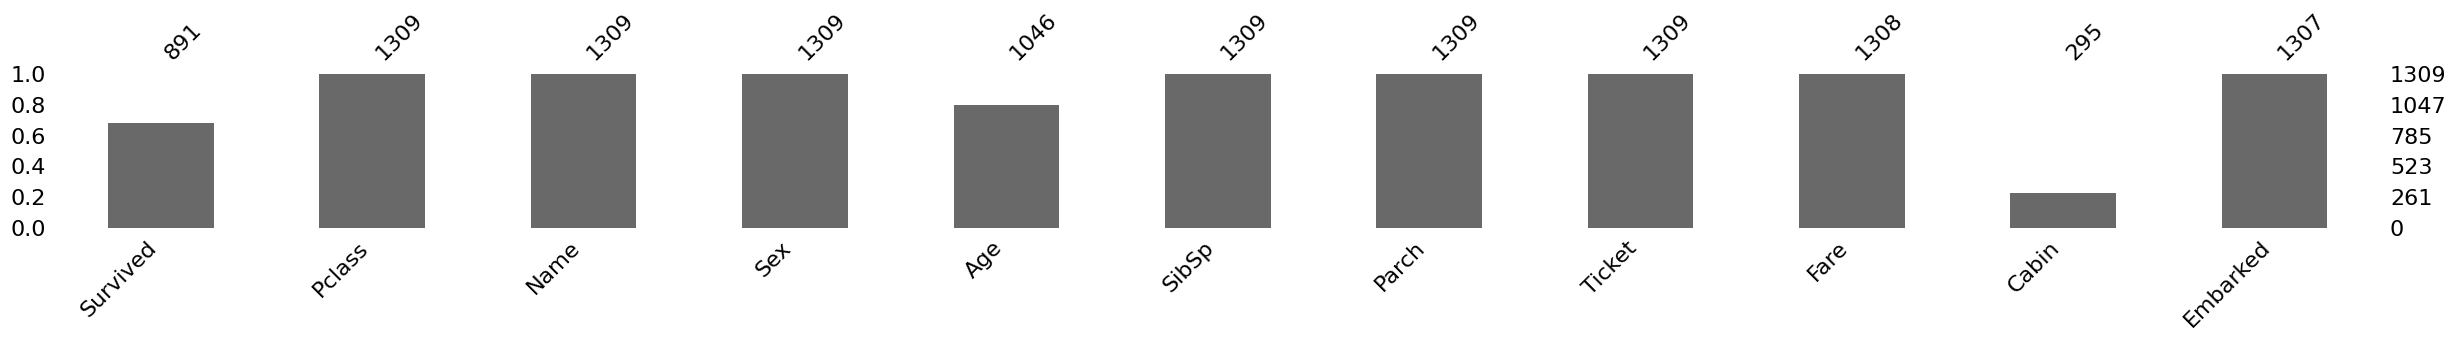

In [120]:
msno.bar(df, figsize=(30,2))

In [121]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


In [122]:
df.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,1309,1309,1309,295,1307
unique,1307,2,929,186,3
top,"Kelly, Mr. James",male,CA. 2343,C23 C25 C27,S
freq,2,843,11,6,914


<iframe src="https://www.kaggle.com/embed/nikitakudriashov/top-1-titanic-solution?cellIds=8&kernelSessionId=100522922" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Top 1% Titanic solution"></iframe>

<iframe src="https://www.kaggle.com/embed/nikitakudriashov/top-1-titanic-solution?cellIds=9&kernelSessionId=100522922" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Top 1% Titanic solution"></iframe>

In [123]:
df["Deck"] = df["Cabin"].str[:1]
df["Deck"] = df["Deck"].replace(np.nan,"N/A")
print("All Deck descriptors:")
print(set(df["Deck"].values))

All Deck descriptors:
{'E', 'C', 'N/A', 'F', 'T', 'G', 'A', 'B', 'D'}


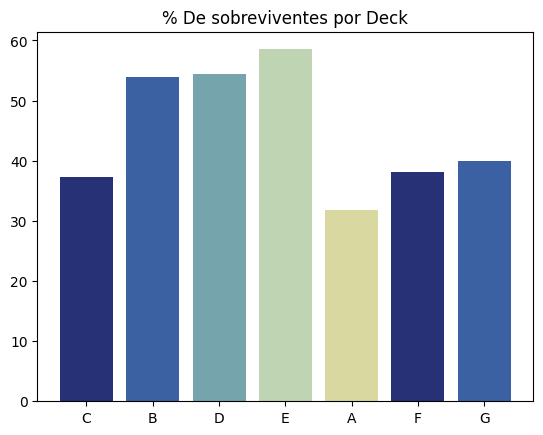

In [124]:
dfplt = df.copy()
dfplt["Survived"] = dfplt["Survived"].astype(str)
dfplt = dfplt[dfplt["Deck"]!="N/A"]
fig = px.histogram(dfplt, x="Deck",color="Survived",
                   color_discrete_sequence=cm)
fig.show()

df_count = dfplt.copy()['Deck'].value_counts().reset_index()
df_temp = dfplt[dfplt['Survived'] == '1.0'].copy()['Deck'].value_counts().reset_index()
df_temp.rename(columns={'count' : 'survivors'}, inplace=True)
df_count = df_count.merge(df_temp, on='Deck', how='left')
df_temp = dfplt[dfplt['Survived'] != '1.0'].copy()['Deck'].value_counts().reset_index()
df_temp.rename(columns={'count' : 'dead'}, inplace=True)
df_count = df_count.merge(df_temp, on='Deck', how='left')
df_count['per_surv'] = df_count['survivors'] / df_count['count'] * 100

plt.bar(x=df_count['Deck'], height=df_count['per_surv'], color=cm)
plt.title("% De sobreviventes por Deck")
plt.show()

<iframe src="https://www.kaggle.com/embed/nikitakudriashov/top-1-titanic-solution?cellIds=12&kernelSessionId=100522922" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Top 1% Titanic solution"></iframe>

In [125]:
df.loc[df["Deck"]=='T',"Deck"] = 'N/A'

In [126]:
replaces = {'B51 B53 B55': 'B55', 'B52 B54 B56': 'B56', 'B57 B59 B63 B66': 'B66', 'B58 B60': 'B60', 
            'B82 B84': 'B84', 'B96 B98': 'B98', 'C22 C26': 'C26', 'C23 C25 C27': 'C27', 'C55 C57': 'C57',
            'C62 C64': 'C64', 'D10 D12': 'D12', 'E39 E41': 'E41', 'F E46': 'E46', 'F E57': 'E57',
            'F E69': 'E69', 'F G63': 'G63', 'F G73': 'G73', 'F': None, 'D': None, ' ': None, 'T': None, np.nan: None}
df["Cabin"] = df["Cabin"].replace(replaces)
df["Cabin"] = df.fillna(np.nan)["Cabin"].str[1:].astype(float)

In [127]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
fig = px.histogram(dfplt, x="Cabin",color="Survived", height=300,
                   color_discrete_sequence=cm)
fig.show()

In [128]:
df["Side"] = df["Cabin"]
df.loc[df["Side"]!=0,"Side"] = (df["Cabin"][df["Cabin"]!=0]%2-0.5)*2

s = df[df["Side"]==1]
print(f'Survived for side 1\t {len(s[s["Survived"]==1])/len(s)}')
s = df[df["Side"]==-1]
print(f'Survived for side -1\t {len(s[s["Survived"]==1])/len(s)}')

Survived for side 1	 0.5076923076923077
Survived for side -1	 0.4276729559748428


### Data prep

<Axes: >

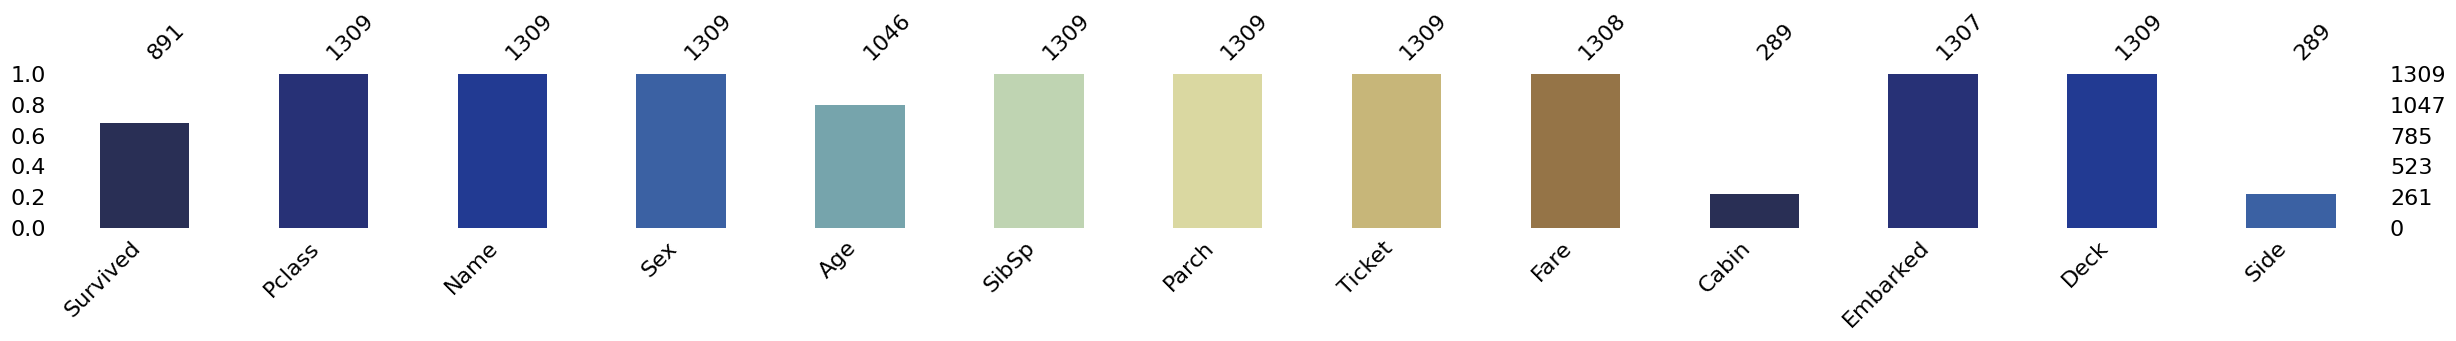

In [129]:
msno.bar(df, figsize=(30,2), color=gradient)


In [130]:
print(df[(df["Pclass"]==1) & (df["Sex"]=="female")]["Age"].median())
print(df[(df["Pclass"]==1) & (df["Sex"]=="male")]["Age"].median())
print(df[(df["Pclass"]==2) & (df["Sex"]=="female")]["Age"].median())
print(df[(df["Pclass"]==2) & (df["Sex"]=="male")]["Age"].median())
print(df[(df["Pclass"]==3) & (df["Sex"]=="female")]["Age"].median())
print(df[(df["Pclass"]==3) & (df["Sex"]=="male")]["Age"].median())

36.0
42.0
28.0
29.5
22.0
25.0


In [131]:
from itertools import *
l1, l2 = [1,2,3], ["female","male"]
for c,s in product(l1,l2):
    msk = (df["Pclass"]==c) & (df["Sex"]==s)
    df.loc[msk,"Age"] = df[msk]["Age"].fillna(df[msk]["Age"].median())

In [132]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
fig = px.scatter(dfplt, x="Age", y="Name", color = "Survived", size_max=6,
                 width=1200, height=500,color_discrete_sequence=cm)
fig.show()

In [133]:
print(df.loc[1044])
df.loc[1044,"Fare"] = df[df["Pclass"]==3]["Fare"].mean()

Survived                   NaN
Pclass                       3
Name        Storey, Mr. Thomas
Sex                       male
Age                       60.5
SibSp                        0
Parch                        0
Ticket                    3701
Fare                       NaN
Cabin                      NaN
Embarked                     S
Deck                       N/A
Side                       NaN
Name: 1044, dtype: object


In [134]:
df["Fare"] = df["Fare"].rank(method='max')

In [135]:
dfplt = df.copy(deep=True)
dfplt["Survived"] = dfplt["Survived"].astype(str)
fig = px.scatter(dfplt, x="Fare", y="Name", color = "Survived", size_max=6,
                 width=1200, height=500,color_discrete_sequence=cm)
fig.show()

In [136]:
df[df["Embarked"].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck,Side
PassengerId,,,,,,,,,,,,,
62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,1194.0,28.0,NaN,B,-1.0
830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,1194.0,28.0,NaN,B,-1.0


In [137]:
df.loc[df["Embarked"].isna(),"Embarked"] = "S"


<Axes: >

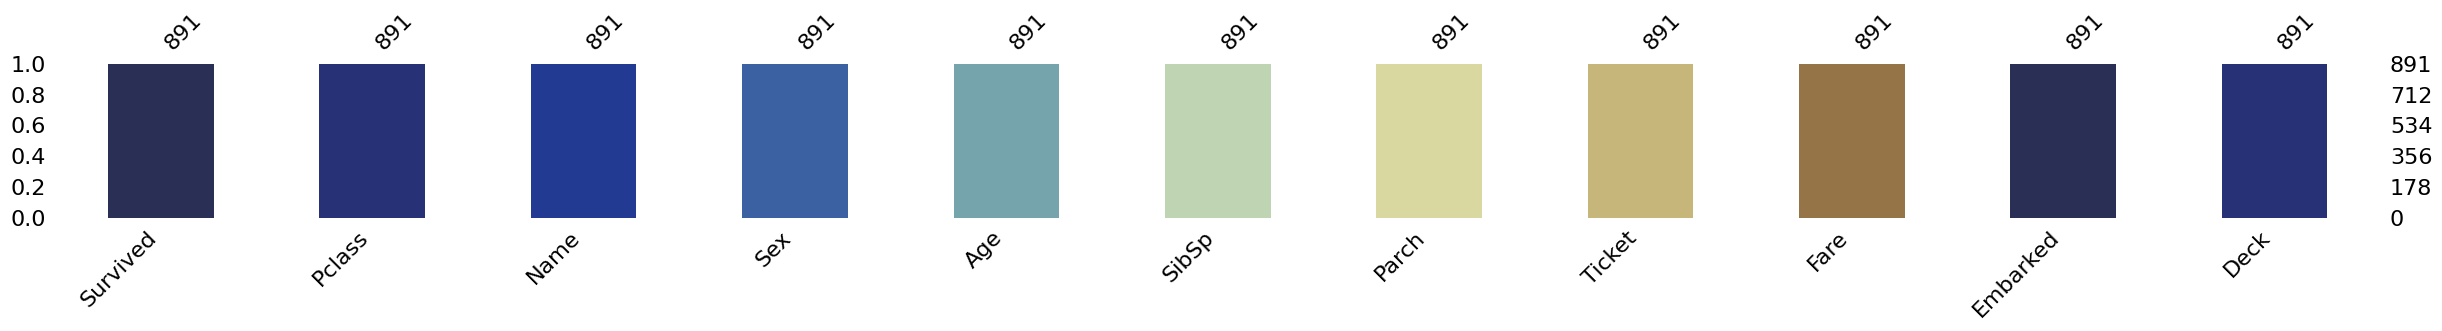

In [142]:
msno.bar(df, figsize=(30,2), color=gradient)

In [139]:
df.dropna(subset=['Survived'], inplace=True)
df.drop(columns=['Cabin', 'Side'], inplace=True)

In [140]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked', 'Deck'], dtype='object')

In [145]:
onehot_df = pd.DataFrame(index=df.index)

for c in ["Pclass","Sex","Embarked","Deck"]:
    encoded = OneHotEncoder().fit_transform(df[c].to_numpy().reshape(-1,1)).toarray()
    columns = [f"{c}_{i}" for i in range(encoded.shape[1])]
    _df =pd.DataFrame(data=encoded, columns=columns, index=df.index)
    onehot_df = pd.concat([_df,onehot_df], axis=1)
    
onehot_df = pd.concat([onehot_df,df[["Survived","Age","SibSp","Parch","Fare"]]], axis=1)

for c in ["Age","Fare","SibSp","Parch"]:
    onehot_df[c] = MinMaxScaler().fit_transform(onehot_df[c].to_numpy().reshape(-1,1))

### Model development

In [146]:
df_train = onehot_df.copy(deep=True)
mask = df_train["Survived"].isna()
train, deploy = df_train[~mask], df_train[mask]
deploy = deploy.drop("Survived", axis=1)
train.loc[:,"Survived"] = train.loc[:,"Survived"].astype(bool)
x_train, y_train = train.drop("Survived", axis=1), train["Survived"].astype(int)

/tmp/ipykernel_12523/2058455189.py:5: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False  True  True  True False False False False  True  True  True  True
 False False False  True False  True False  True False  True  True  True
 False  True False False  True False False  True  True False False False
  True False False  True False False False  True  True False False  True
 False False False False  True  True False  True  True False  True False
 False  True False False False  True  True False  True False False False
 False False  True False False False  True  True False  True  True False
  True  True False False  True False False False False False False False
 False  True  True False False False False False False False  True  True
 False  True False False False False False False False False False False
 False False False  True False  True False  True  True False False False
 False  True False False  True False Fal

In [147]:
import numpy as np
import scipy
setattr(scipy, "interp", np.interp)  # cria scipy.interp apontando para np.interp

import scikitplot as skplt

deploy_acc, train_acc, models_dict= {},{},{}

def baseline(name, model, verbose=True):
    models_dict[name] = model
    models_dict[name].fit(x_train,y_train)
    y_train_hat = models_dict[name].predict(x_train)
    train_acc[name] = accuracy_score(y_train,y_train_hat)
    if verbose:
        skplt.metrics.plot_confusion_matrix(y_train, y_train_hat, normalize=True, figsize=(5,5))
    submition = pd.DataFrame(models_dict[name].predict(deploy), index= deploy.index,columns = ["Survived"]).astype(int)
    submition.to_csv(f'{name}.csv')

In [149]:
# params = {"penalty":"l2","solver": "liblinear","C":0.2,}
# name, model = "lr_baseline", LogisticRegression(**params)
# baseline(name, model, verbose=False)

name, model = "svm_baseline", SVC(**{'C': 5, 'degree': 2, 'gamma': 0.1, 'kernel': 'poly'})
baseline(name, model, verbose=False)

# params = {"eta":0.1,"gamma":0,"max_depth":6,"lambda":0.1,"alpha":10}
# name, model = "xg_baseline", XGBClassifier(**params)
# baseline(name, model, verbose=False)

# params = {"rsm":0.1, "learning_rate":0.005,"iterations":500,"l2_leaf_reg":5,"verbose":False}
# name, model = "cb_baseline", CatBoostClassifier(**params)
# baseline(name, model, verbose=False)

ValueError: Found array with 0 sample(s) (shape=(0, 20)) while a minimum of 1 is required by SVC.